In [6]:
import os
import math
import pandas as pd
import numpy as np
import seaborn as sns
from pandas import datetime
from matplotlib import pyplot as plt


from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Using TensorFlow backend.
//miniconda3/envs/TPOT/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
//miniconda3/envs/TPOT/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
//miniconda3/envs/TPOT/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
//miniconda3/envs/TPOT/lib/python3.5/site-packages/tenso

In [232]:
# convert one to multiple series
def lag_ahead_series(data, n_in=1, n_out=1, n_vars = 1,dropnan=True):
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for j in range(n_vars):
        for i in range(n_in, 0, -1):
            cols.append(df.iloc[:,j].shift(i))
            names.append('var{}(t-{})'.format(j+1, i))
    
    # forecast sequence (t+1, ... t+n)
    for j in range(n_vars):
        for i in range(0, n_out):
            cols.append(df.iloc[:,j].shift(-i))
            names += [('var{}(t+{})'.format(j+1, i)) ]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    #drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

## Distribution plot funciton
def distri_plot(df):
    f, axes = plt.subplots(3, 3, figsize=(15, 11), sharex=False)
    for idx, col_name in enumerate(df.columns, 0): 
        idx = int(idx)
        ## jump to plotting energy
        if(col_name == "rain"):
            sns.distplot(df["energy"],ax=axes[2,2])
            return
        sns.distplot(df[col_name],ax=axes[idx//3,idx%3])  
    ## plot     
    plt.tight_layout()

## Scatter plot function
def scatter_plot(df):
    f, axes = plt.subplots(4, 2, figsize=(15, 11), sharex=False)
    for idx, col_name in enumerate(df.columns, 0): 
        idx = int(idx)
        if(idx >= 8):
            return
        ## jump to plotting energy
        sns.scatterplot(x= col_name,y = "energy", data = df, ax=axes[idx//2,idx%2])  
    ## plot     
    plt.tight_layout()
    

In [159]:
train = pd.read_csv("train.csv", index_col = "time")
test = pd.read_csv("test.csv", index_col = "time")

### Seeking outliers

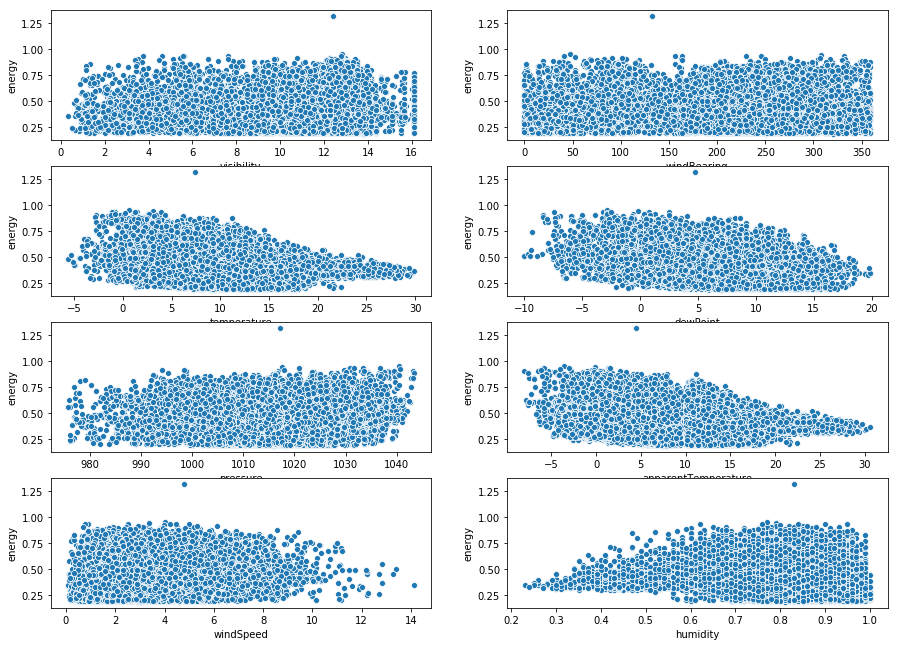

In [244]:
scatter_plot(train)

In [242]:
## deal with the only outliers in  energy data 
train.drop(train[(train["energy"] > 20)].index, inplace = True)
train.reset_index(drop=True, inplace=True)

### Calibration of distribution

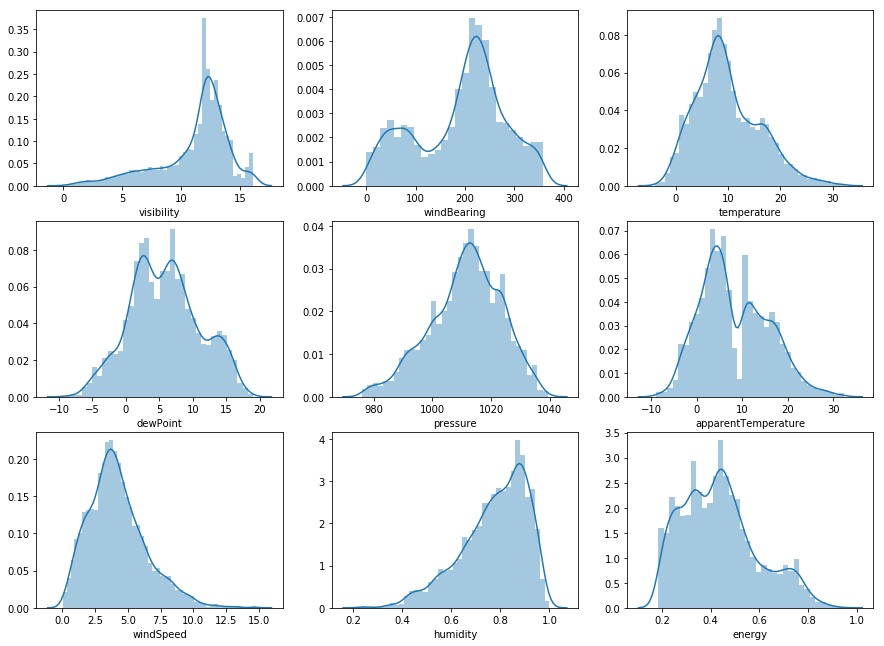

In [245]:
distri_plot(test)


We can observe that **visibility**, **windSpeed**, **humidty** 

In [98]:
we.head(10)

,visibility,windBearing,temperature,dewPoint,pressure,apparentTemperature,windSpeed,humidity,av_kWh/hh
Unnamed: 0,,,,,,,,,
2011-12-11 00:00:00,12.50,210,2.83,1.17,1015.67,1.11,1.78,0.89,0.495915
2011-12-11 01:00:00,12.65,204,2.48,0.81,1014.96,0.31,2.11,0.89,0.443318
2011-12-11 02:00:00,13.02,214,2.70,1.29,1014.42,0.11,2.57,0.90,0.347353
2011-12-11 03:00:00,13.05,211,3.47,1.41,1013.78,0.66,3.00,0.86,0.315408
2011-12-11 04:00:00,12.97,204,3.74,1.53,1012.94,1.29,2.64,0.85,0.278582
2011-12-11 05:00:00,12.68,201,4.23,2.48,1012.42,1.82,2.70,0.88,0.297687
2011-12-11 06:00:00,12.54,199,5.16,3.01,1011.74,3.03,2.57,0.86,0.334428
2011-12-11 07:00:00,12.50,198,4.98,3.13,1011.26,2.39,3.12,0.88,0.335080
2011-12-11 08:00:00,12.01,190,5.79,3.73,1010.85,3.13,3.48,0.87,0.418856


In [121]:
from sklearn.preprocessing import StandardScaler
scaler = MinMaxScaler()

standwe = pd.DataFrame(scaler.fit_transform(we), index = we.index, columns = we.columns)


In [122]:
standwe['humidity'] = standwe.humidity.apply(lambda x : np.log1p(x))

standwe['apparentTemperature'] = standwe.humidity.apply(lambda x : np.log1p(x))

In [126]:
standwe.head(10)

,visibility,windBearing,temperature,dewPoint,pressure,apparentTemperature,windSpeed,humidity,av_kWh/hh
Unnamed: 0,,,,,,,,,
2011-12-11 00:00:00,0.773072,0.584958,0.222660,0.373409,0.590855,0.481833,0.117886,0.619039,0.477933
2011-12-11 01:00:00,0.782554,0.568245,0.213460,0.361353,0.580349,0.481833,0.140244,0.619039,0.416470
2011-12-11 02:00:00,0.805942,0.596100,0.219243,0.377428,0.572359,0.486128,0.171409,0.626008,0.304329
2011-12-11 03:00:00,0.807838,0.587744,0.239485,0.381447,0.562888,0.468651,0.200542,0.597837,0.266999
2011-12-11 04:00:00,0.802781,0.568245,0.246583,0.385466,0.550459,0.464154,0.176152,0.590669,0.223966
2011-12-11 05:00:00,0.784450,0.559889,0.259464,0.417281,0.542764,0.477489,0.180217,0.612022,0.246290
2011-12-11 06:00:00,0.775601,0.554318,0.283912,0.435030,0.532702,0.468651,0.171409,0.597837,0.289225
2011-12-11 07:00:00,0.773072,0.551532,0.279180,0.439049,0.525599,0.477489,0.208672,0.612022,0.289986
2011-12-11 08:00:00,0.742099,0.529248,0.300473,0.459143,0.519532,0.473095,0.233062,0.604954,0.387884


**Plot distribution after standardization**

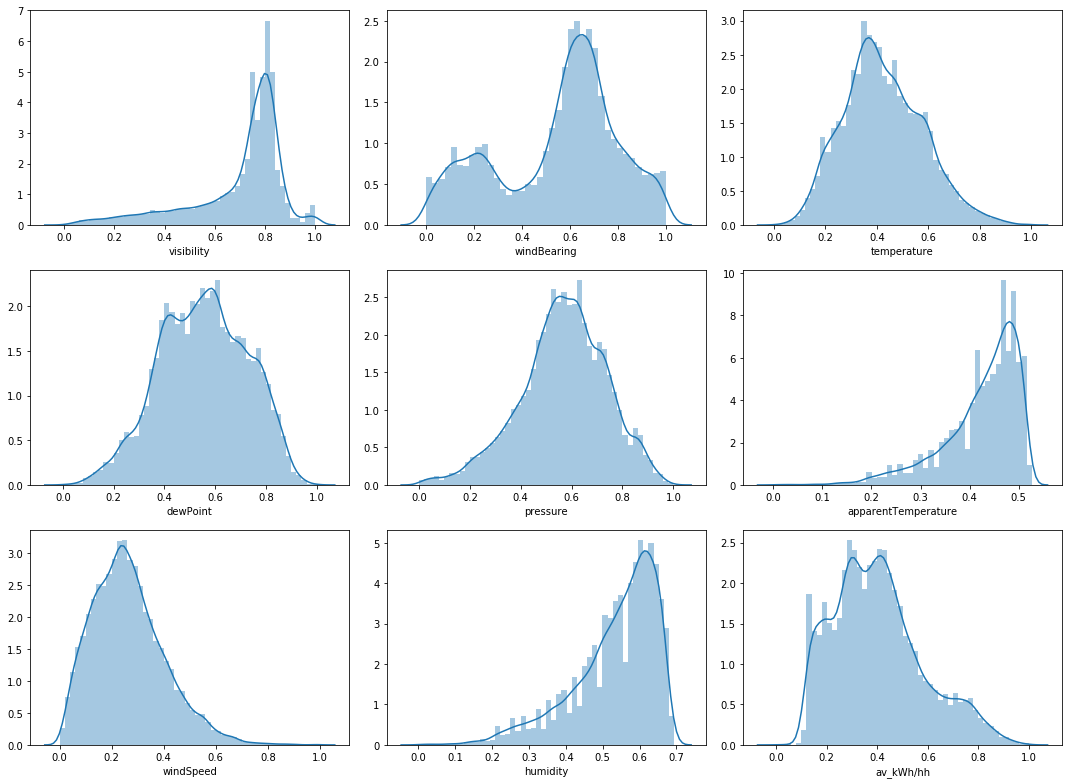

In [127]:
f, axes = plt.subplots(3, 3, figsize=(15, 11), sharex=False)

i = 0;
j = -1;
for idx in standwe.columns:
    j += 1
    sns.distplot(standwe[idx],ax=axes[i,j])
    if(j ==2):
        i += 1
        j = -1
plt.tight_layout()

In [132]:
weather_energy.dropna(inplace=True)

**Creat lag ahead scenarios**

In [133]:
#create 48 hours recency effect matrix
lag = lag_ahead_series(weather_energy.iloc[:,1:8], 48, 0, 7)


In [134]:
#create 48 housrs ahead energy consumption matrix
ahead = lag_ahead_series(weather_energy.iloc[:,9],0,49,True)

In [135]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(lag, ahead, train_size = 0.7, test_size = 0.3)
min_max_scaler =MinMaxScaler()
X_train_minmax = min_max_scaler.fit_transform(train_X)
y_train_minmax = min_max_scaler.fit_transform(train_y)
X_test_minmax = min_max_scaler.fit_transform(test_X)
y_test_minmax = min_max_scaler.fit_transform(test_y)


**PCA (have some problems)**

In [119]:
from sklearn.decomposition import PCA

pca = PCA(n_components=10, svd_solver='arpack')
pca.fit(X_train_minmax)
pca.explained_variance_ratio_.sum()


0.6358931453959614

In [120]:
pca.transform(X_train_minmax).shape

(19803, 10)

**Feature Selection**

In [134]:
# L1 based(temporarily not working probably data too noisy )
from sklearn.linear_model import MultiTaskLasso
from sklearn.feature_selection import SelectFromModel
MulL = MultiTaskLasso(alpha=1, fit_intercept=True, normalize=False, copy_X=True, max_iter=1000, 
 tol=0.0001, warm_start=False, random_state=None, selection='cyclic').fit(X_train_minmax,y_train_minmax)
model = SelectFromModel(MulL, prefit=True)
X_new = model.transform(X_train_minmax)


//miniconda3/envs/TPOT/lib/python3.5/site-packages/sklearn/feature_selection/_base.py:81: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  UserWarning)


In [138]:
# Tree based
from sklearn.tree import ExtraTreeRegressor
from sklearn.feature_selection import SelectFromModel
reg = ExtraTreeRegressor(random_state=0).fit(X_test_minmax,y_test_minmax)
model = SelectFromModel(reg, prefit=True)
X_new = model.transform(X_train_minmax)


In [140]:
X_new

array([[0.78381795, 0.53522608, 0.47791798, ..., 0.69709443, 0.66626006,
        0.64452072],
       [0.72060683, 0.35015773, 0.3882755 , ..., 0.31476998, 0.30885582,
        0.30742829],
       [0.52844501, 0.2807571 , 0.34595163, ..., 0.36125908, 0.40692852,
        0.41235597],
       ...,
       [0.8091024 , 0.55362776, 0.57991588, ..., 0.22978208, 0.21615028,
        0.22431969],
       [0.8539823 , 0.54968454, 0.58228181, ..., 0.18038741, 0.16833374,
        0.16695268],
       [0.71744627, 0.32281809, 0.356204  , ..., 0.34067797, 0.35496463,
        0.35793087]])

In [83]:
amatrix = ahead.values
lmatrix = lag.values
#weather_feature = weather_energy.iloc[:19803,1:].values
amatrix.shape, lmatrix.shape
#print(lmatrix.shape)

((19803, 49), (19803, 384))

In [84]:
##for manual regression algorithm
merge = np.concatenate((lmatrix[:19000,:], amatrix[:19000,:]),axis = 1)
scaler = MinMaxScaler(feature_range=(0, 1))
merge = scaler.fit_transform(merge)
X = merge[:,:384]
## Too many features need dimension reduction
y = merge[:,384:]
X.shape, y.shape

((19000, 384), (19000, 49))

In [89]:
##preserve data for testing
merge = np.concatenate((lmatrix[19000:19803,:], amatrix[19000:19803,:]),axis = 1)
scaler = MinMaxScaler(feature_range=(0, 1))
merge = scaler.fit_transform(merge)
test_X = merge[:,:384]
test_y = merge[:,384:]
test_X.shape, test_y.shape

((803, 384), (803, 49))

In [34]:
##for TPOT 
X = lmatrix[:500,:]
y = amatrix[:500,:]
X.shape, y.shape

((500, 384), (500, 49))

**TPOT**

In [28]:
from tpot import TPOTRegressor
from sklearn.model_selection import train_test_split
from tpot_multi import mul_reg_config_dict
train_X, test_X, train_y, test_y = train_test_split(X_new[:3000,:], y_train_minmax[:3000,:], train_size = 0.7, test_size = 0.3)
#import mul_config as mc## import multioutput regressor customized configuration

tpot_reg = TPOTRegressor(generations=10, population_size=20, n_jobs=1, verbosity=3, random_state=666, config_dict=mul_reg_config_dict)
tpot_reg.fit(train_X, train_y)


2 operators have been imported by TPOT.


_pre_test decorator: _random_mutation_operator: num_test=0 all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 2450 and the array at index 1 has size 50.
_pre_test decorator: _random_mutation_operator: num_test=0 all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 2450 and the array at index 1 has size 50.
_pre_test decorator: _random_mutation_operator: num_test=1 all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 2450 and the array at index 1 has size 50.
_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required..
_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required..
Generation 1 - Curren

_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required..
_pre_test decorator: _random_mutation_operator: num_test=0 all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 2450 and the array at index 1 has size 50.
_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required..
_pre_test decorator: _random_mutation_operator: num_test=0 all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 2450 and the array at index 1 has size 50.
_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required..
_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a m

_pre_test decorator: _random_mutation_operator: num_test=0 all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 2450 and the array at index 1 has size 50.
_pre_test decorator: _random_mutation_operator: num_test=0 all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 2450 and the array at index 1 has size 50.
_pre_test decorator: _random_mutation_operator: num_test=0 all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 2450 and the array at index 1 has size 50.
_pre_test decorator: _random_mutation_operator: num_test=1 all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 2450 and the array at index 1 has size 50.
_pre_test decorator: _random_mutation_operator: num_test=0 Found arr

TPOTRegressor(config_dict={'sklearn.ensemble.RandomForestRegressor': {'bootstrap': [True,
                                                                                    False],
                                                                      'max_features': array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
                                                                      'min_samples_leaf': range(1, 21),
                                                                      'min_samples_split': range(2, 21),
                                                                      'n_estimators': [100]},
                           'sklearn.feature_selection.SelectFromModel': {'estimator': {...
              crossover_rate=0.1, cv=5, disable_update_check=False,
              early_stop=None, generations=10, max_eval_time_mins=5,
              max_time_mins=None, memory=None, multi_output=True,

In [29]:
tpot_reg.export("400.py")

In [81]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from tpot.export_utils import set_param_recursive

# NOTE: Make sure that the outcome column is labeled 'target' in the data file
train_X, test_X, train_y, test_y = train_test_split(X_new, y_train_minmax, train_size = 0.7, test_size = 0.3)
# Average CV score on the training set was: -0.008001795169452104
rfr = RandomForestRegressor(bootstrap=False, max_features=0.4, min_samples_leaf=1, min_samples_split=3, n_estimators=100)
# Fix random state for all the steps in exported pipeline

rfr.fit(train_X, train_y)
yhat = rfr.predict(test_X)


In [82]:
yhat.shape, test_y.shape

((5941, 49), (5941, 49))

**Result evaluation**

In [83]:
import math
rmse = math.sqrt(mean_squared_error(test_y, yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.072


In [84]:
real = test_y
guess = yhat

real.shape, guess.shape

real = real[:1,:49]
guess = guess[:1,:49]

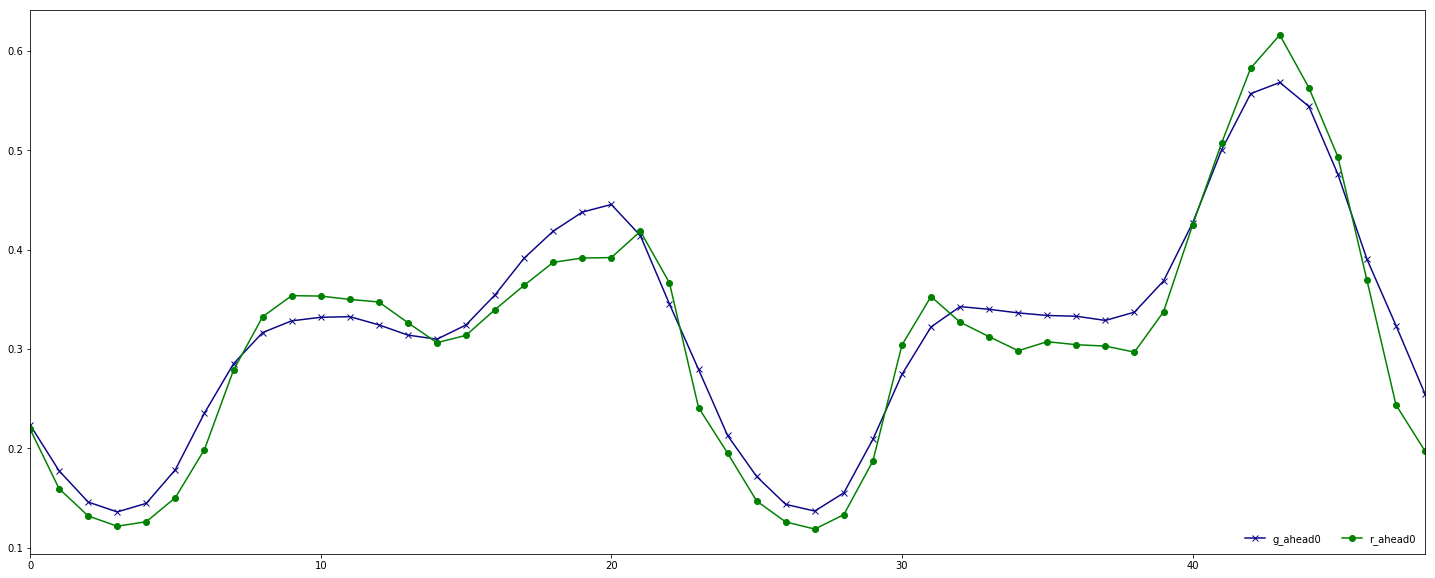

In [85]:
from matplotlib import cm
import matplotlib.pyplot as plt
rpdf = pd.DataFrame()
gpdf = pd.DataFrame()

i = 0
for row in real:
    rpdf.insert(i, "r_ahead{}".format(i), row, True) 
    i += 1

i = 0
for row in guess:
    gpdf.insert(i, "g_ahead{}".format(i), row, True) 
    i += 1
#plot 
ax = plt.gca()
gpdf.plot(figsize=(25,10), colormap = 'plasma',style='-x',legend = True, ax = ax)
rpdf.plot(figsize=(25,10), color = 'g',style ='-o',legend = True, ax = ax)
ax.legend(frameon=False, loc='lower right', ncol=6)
#for key in gpdf:
#    gpdf['{}'.format(key)].plot(colormap = 'Greens',style='-',legend = True)
    
plt.show()



**random forest regression**

In [46]:
.shape

(19803, 49)

In [62]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(X_new, y_train_minmax, train_size = 0.7, test_size = 0.3)
rfr = RandomForestRegressor(max_depth=10, random_state=0, n_estimators=100)
rfr.fit(train_X, train_y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [63]:
yhat = rfr.predict(test_X)

In [64]:
yhat.shape

(5941, 49)

In [65]:
test_y.shape

(5941, 49)

In [169]:
#extact predicted values but reverse normalization first
yhat = rfr.predict(test_X)
inv_yhat = np.concatenate((test_X, yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:1,384:]
#extract exact values but reverse normalization first
inv_y = np.concatenate((test_X, test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:49,384:385]



In [170]:
inv_yhat.shape, inv_y.shape

((1, 49), (49, 1))

**Result evaluation**

In [66]:
#mean square error between exact and predict values
import math
rmse = math.sqrt(mean_squared_error(test_y, yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.095


In [67]:
#data preprocess
real = test_y
guess = yhat

real.shape, guess.shape

real = real[:1,:49]
guess = guess[:1,:49]

In [9]:
weather_energy.head(1)

,Unnamed: 0,visibility,windBearing,temperature,dewPoint,pressure,apparentTemperature,windSpeed,humidity,av_kWh/hh
0,2011-12-11 00:00:00,12.5,210,2.83,1.17,1015.67,1.11,1.78,0.89,0.495915


In [12]:
bootstrap_ci(weather_energy, "av_kWh/hh", "")

Point estimate of difference between means: 0.02
95.0 % confidence interval for the difference between means: (-0.05, 0.23)


In [5]:
import numpy as np

def bootstrap_ci(df, variable, classes, repetitions = 1000, alpha = 0.05, random_state=None):
    # df: a data frame that includes observations of the two sample
    # variable: the column name of the column that includes observations
    # classes: the column name of the column that includes group assignment (This column should contain two different group names)
    # repetitions: number of times you want the bootstrapping to repeat. Default is 1000.
    # alpha: likelihood that the true population parameter lies outside the confidence interval. Default is 0.05. 
    # random_stata: enable users to set their own random_state, default is None. 
    
    df = df[[variable, classes]]
    bootstrap_sample_size = len(df) 
    
    mean_diffs = []

    for i in range(repetitions):
        bootstrap_sample = df.sample(n = bootstrap_sample_size, replace = True, random_state = random_state)
        mean_diff = bootstrap_sample.groupby(classes).mean().iloc[1,0] - bootstrap_sample.groupby(classes).mean().iloc[0,0]
        mean_diffs.append(mean_diff)

    # confidence interval
    left = np.percentile(mean_diffs, alpha/2*100)
    right = np.percentile(mean_diffs, 100-alpha/2*100)

    # point estimate
    point_est = df.groupby(classes).mean().iloc[1,0] - df.groupby(classes).mean().iloc[0,0]

    print('Point estimate of difference between means:', round(point_est,2))
    print((1-alpha)*100,'%','confidence interval for the difference between means:', (round(left,2), round(right,2)))  

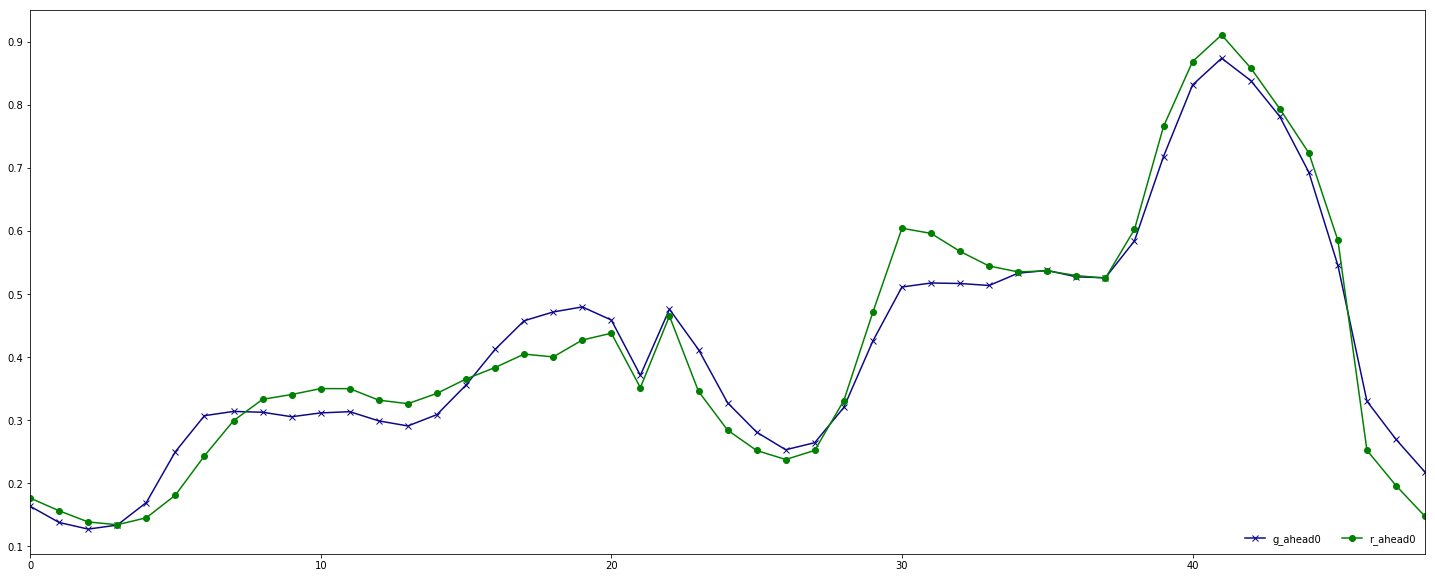

In [68]:
from matplotlib import cm
import matplotlib.pyplot as plt
rpdf = pd.DataFrame()
gpdf = pd.DataFrame()

i = 0
for row in real:
    rpdf.insert(i, "r_ahead{}".format(i), row, True) 
    i += 1

i = 0
for row in guess:
    gpdf.insert(i, "g_ahead{}".format(i), row, True) 
    i += 1
#plot 
ax = plt.gca()
gpdf.plot(figsize=(25,10), colormap = 'plasma',style='-x',legend = True, ax = ax)
rpdf.plot(figsize=(25,10), color = 'g',style ='-o',legend = True, ax = ax)
ax.legend(frameon=False, loc='lower right', ncol=6)
#for key in gpdf:
#    gpdf['{}'.format(key)].plot(colormap = 'Greens',style='-',legend = True)
    
plt.show()

**LSTM**

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1, 50)             25800     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 1, 49)             2499      
Total params: 28,299
Trainable params: 28,299
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
 - 3s - loss: 0.1620
Epoch 2/50
 - 2s - loss: 0.1154
Epoch 3/50
 - 2s - loss: 0.1050
Epoch 4/50
 - 2s - loss: 0.0978
Epoch 5/50
 - 2s - loss: 0.0928
Epoch 6/50
 - 2s - loss: 0.0894
Epoch 7/50
 - 2s - loss: 0.0876
Epoch 8/50
 - 2s - loss: 0.0863
Epoch 9/50
 - 2s - loss: 0.0852
Epoch 10/50
 - 2s - loss: 0.0843
Epoch 11/50
 - 2s - loss: 0.0837
Epoch 12/50
 - 2s - loss: 0.0831
Epoch 13/50
 - 2s - loss: 0.0826
Epoch 14/50
 - 2s - loss: 0.0821
Epoch 15/50
 - 2s - loss: 0.0817
Epoch 16/50
 - 2s - loss: 0.0813
Epoch 17/50
 - 

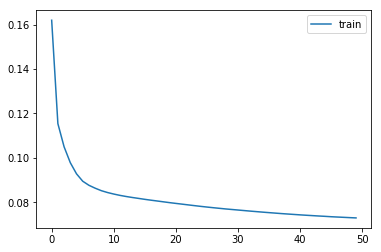

In [37]:
train_X, val_X, train_y, val_y = train_test_split(X_new, y_train_minmax, train_size = 0.9, test_size = 0.1)
ltrain_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
lval_X = val_X.reshape((val_X.shape[0], 1, val_X.shape[1]))
ltrain_y = train_y.reshape((train_y.shape[0],1, train_y.shape[1]))

from keras.layers import TimeDistributed
# design network
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(ltrain_X.shape[1], ltrain_X.shape[2]),return_sequences = True))
model.add(TimeDistributed(Dense(49)))
model.compile(loss='mae', optimizer='adam')
model.summary()
# fit network
history = model.fit(ltrain_X, ltrain_y, epochs=50, batch_size=72, verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.legend()
pyplot.show()

In [40]:
test_X.shape

(5941, 1, 78)

In [39]:

test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

#ltrain_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
#lval_X = val_X.reshape((val_X.shape[0], 1, val_X.shape[1]))
#ltrain_y = train_y.reshape((train_y.shape[0],1, train_y.shape[1]))


In [97]:
ptest_X.shape, test_y.shape

((803, 384), (803, 49))

In [41]:
yhat = model.predict(test_X)
yhat = yhat.reshape(yhat.shape[0],yhat.shape[2])
ptest_X = test_X.reshape(test_X.shape[0], test_X.shape[2])
# invert scaling for "predict"
#inv_yhat = np.concatenate((ptest_X, yhat), axis=1)
#inv_yhat = scaler.inverse_transform(inv_yhat)



In [42]:
test_y.shape

(5941, 49)

In [98]:
# invert scaling for "actual"
#ltest_y = test_y.reshape((len(test_y), 8))
inv_y = np.concatenate((ptest_X, test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_yhat = inv_yhat[:,384:]
inv_y = inv_y[:,384:]

In [99]:
inv_y.shape, inv_yhat.shape


((803, 49), (803, 49))

**performace**


In [46]:
import math
rmse = math.sqrt(mean_squared_error(test_y, yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.098


In [43]:
#data preprocess
real = test_y
guess = yhat

real = real[:1,:]
guess = guess[:1,:]

In [44]:
real.shape, guess.shape

((1, 49), (1, 49))

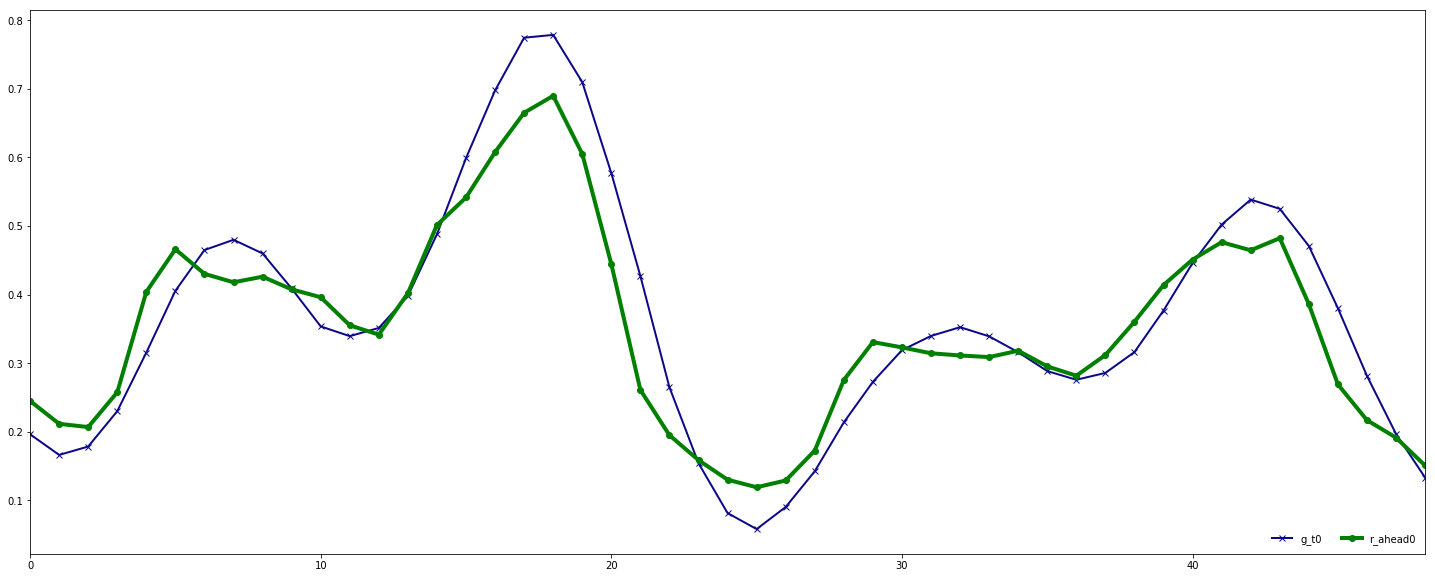

In [45]:
from matplotlib import cm
import matplotlib.pyplot as plt
rpdf = pd.DataFrame()
gpdf = pd.DataFrame()

ax = plt.gca()
i = 0
for row in real:
    rpdf.insert(i, "r_ahead{}".format(i), row, True) 
    i += 1

i = 0
for row in guess:
    gpdf.insert(i, "g_t{}".format(i), row, True) 
    
    i += 1
    
#plot 
gpdf.plot(figsize=(25,10),colormap='plasma',style='-x',legend = True, ax = ax, lw = 2)
rpdf.plot(figsize=(25,10), color='Green',style ='-o',legend = True, ax = ax, lw = 4)
ax.legend(frameon=False, loc='lower right', ncol=6)
#for key in gpdf:
#    gpdf['{}'.format(key)].plot(colormap = 'Greens',style='-',legend = True)
    
plt.show()

**XGBoost**

In [49]:
import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor
xreg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1, max_depth = 5, alpha = 10, n_estimators = 10)
mreg = MultiOutputRegressor(xreg)
mreg.fit(train_X, train_y)


ImportError: No module named 'xgboost'

In [76]:
#extact predicted values but reverse normalization first
yhat = mreg.predict(test_X)
inv_yhat = np.concatenate((test_X, yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,384:]
#extract exact values but reverse normalization first
inv_y = np.concatenate((test_X, test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,384:]



**Performance**


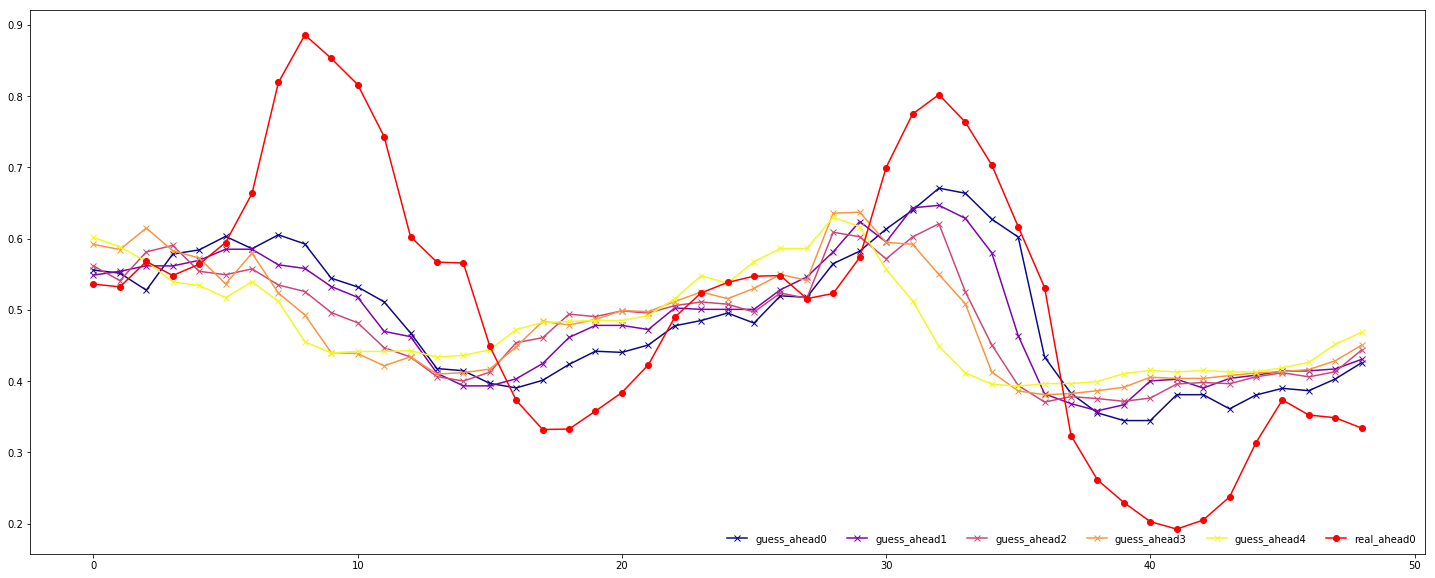

In [100]:
rpdf = pd.DataFrame()
gpdf = pd.DataFrame()

i = 0
for row in real:
    rpdf.insert(i, "real_ahead{}".format(i), row, True) 
    i += 1

i = 0
for row in guess:
    gpdf.insert(i, "guess_ahead{}".format(i), row, True) 
    i += 1
#plot 
ax = plt.gca()
gpdf.plot(figsize=(25,10), colormap = 'plasma',style='-x',legend = True, ax = ax)
rpdf.plot(figsize=(25,10), color = 'Red',style ='-o',legend = True, ax = ax)
ax.legend(frameon=False, loc='lower right', ncol=6)
#for key in gpdf:
#    gpdf['{}'.format(key)].plot(colormap = 'Greens',style='-',legend = True)
    
plt.show()

In [83]:
#data preprocess
real = np.transpose(inv_y)
guess = np.transpose(inv_yhat)

real.shape, guess.shape

#real = real[:1,:49]
#guess = guess[:5,:49]

((49, 1000), (49, 1000))

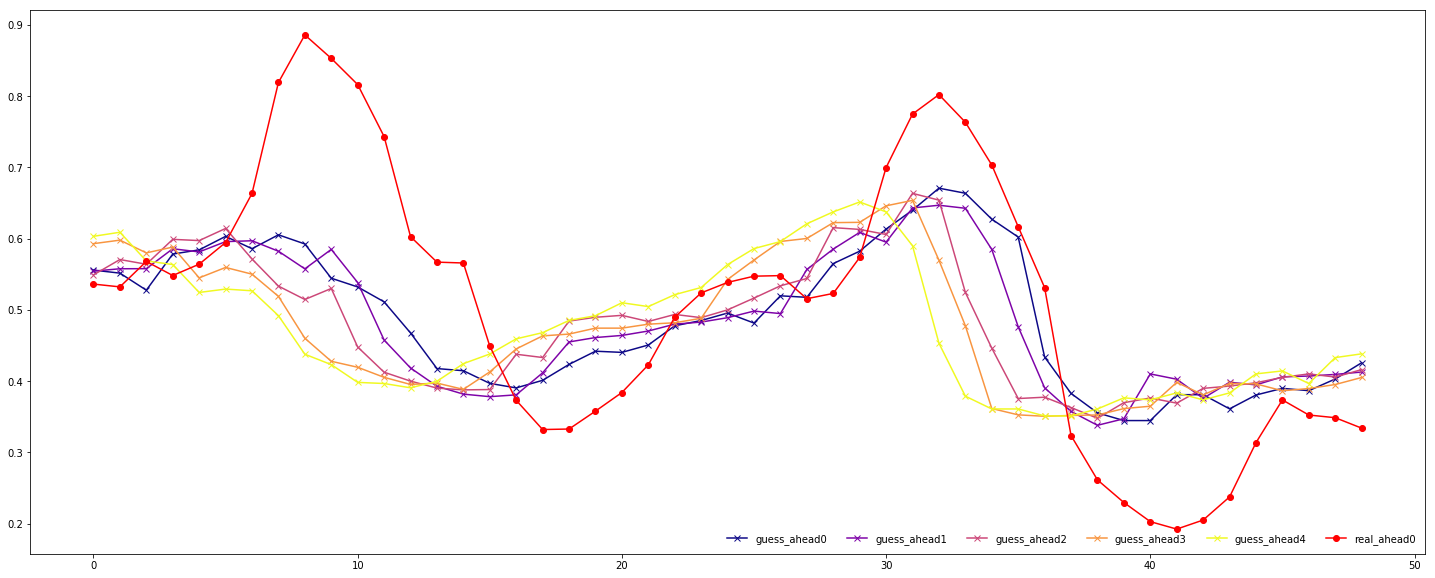

In [78]:
rpdf = pd.DataFrame()
gpdf = pd.DataFrame()

i = 0
for row in real:
    rpdf.insert(i, "real_ahead{}".format(i), row, True) 
    i += 1

i = 0
for row in guess:
    gpdf.insert(i, "guess_ahead{}".format(i), row, True) 
    i += 1
#plot 
ax = plt.gca()
gpdf.plot(figsize=(25,10), colormap = 'plasma',style='-x',legend = True, ax = ax)
rpdf.plot(figsize=(25,10), color = 'Red',style ='-o',legend = True, ax = ax)
ax.legend(frameon=False, loc='lower right', ncol=6)
#for key in gpdf:
#    gpdf['{}'.format(key)].plot(colormap = 'Greens',style='-',legend = True)
    
plt.show()

In [97]:
import xgboost as xgb
from sklearn.multioutput import RegressorChain
xreg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1, max_depth = 5, alpha = 10, n_estimators = 10)
mreg = RegressorChain(xreg)
mreg.fit(train_X, train_y)


//miniconda3/envs/TPOT2/lib/python3.5/site-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")


RegressorChain(base_estimator=XGBRegressor(alpha=10, base_score=0.5,
                                           booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=0.3, gamma=0,
                                           importance_type='gain',
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=5, min_child_weight=1,
                                           missing=None, n_estimators=10,
                                           n_jobs=1, nthread=None,
                                           objective='reg:squarederror',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, scale_pos_weight=1,
                                           seed=None, silent=None, subsample=1,
   

In [98]:
#extact predicted values but reverse normalization first
yhat = mreg.predict(test_X)
inv_yhat = np.concatenate((test_X, yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,384:]
#extract exact values but reverse normalization first
inv_y = np.concatenate((test_X, test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,384:]



In [99]:
#data preprocess
real = np.transpose(inv_y)
guess = np.transpose(inv_yhat)

real.shape, guess.shape

real = real[:1,:49]
guess = guess[:5,:49]